In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as BS
from datetime import datetime
import numpy as np
import re
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import plotly.plotly as py
from folium.plugins import MarkerCluster

# Clean Data

In [2]:
#import wiki code as text file

response = requests.get('https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900')
result_text = response.text

In [3]:
#convert text to soup

soup = BS(result_text, 'html.parser')

In [4]:
# convert headers to list

column_headers = [th.getText() for th in 
                  soup.findAll('th')]

In [5]:
# create list of all data in table

data_rows = soup.findAll('tr')[6:] 

In [6]:
# parse out data in rows

earthquake_data = [[td.getText() for td in data_rows[i].findAll('td')]
            for i in range(len(data_rows))]

In [7]:
3

df = pd.DataFrame(earthquake_data, columns=column_headers)

In [8]:
df.columns = ['origin','country','lat','lng','depth','magnitude','secondary_effects','pde_shaking_deaths','pde_total_deaths','utsu_total_deaths','emdat_total_deaths','other_deaths']

In [9]:
df['origin'] = pd.to_datetime(df.origin)

In [10]:
df.other_deaths = df.other_deaths.str[:-1]

In [11]:
#replace all blank cells with NaN

df = df.replace('', np.NaN)

In [12]:
#resolve any weird data errors that have a comma, footnote, or aren't formatted correctly to convert to number

df.at[43, 'other_deaths'] = 8000
df.at[66,'other_deaths'] = 164
df.at[99,'other_deaths'] = 1500
df.at[1078,'other_deaths'] = 45000
df.at[1082,'other_deaths'] = 2489
df.at[1206,'other_deaths'] = 26000
df.at[1238,'other_deaths'] = 283000
df.at[1339,'other_deaths'] = 601
df.at[1338,'other_deaths'] = 111
df.at[1336,'other_deaths'] = 150
df.at[1335,'other_deaths'] = 15894
df.at[1329,'other_deaths'] = 521
df.at[1328,'other_deaths'] = 221517
df.at[1318,'other_deaths'] = 60
df.at[439,'emdat_total_deaths'] = '10'
df.at[413,'emdat_total_deaths'] = ''
df.at[958,'other_deaths'] = '33'
df.at[1327,'other_deaths'] = '1115'
df.at[1332,'other_deaths'] = '2698'

In [13]:
#convert all deaths to numeric

df.pde_shaking_deaths = pd.to_numeric(df.pde_shaking_deaths)
df.pde_total_deaths = pd.to_numeric(df.pde_total_deaths)
df.utsu_total_deaths = pd.to_numeric(df.utsu_total_deaths)
df.emdat_total_deaths = pd.to_numeric(df.emdat_total_deaths)
df.other_deaths = pd.to_numeric(df.other_deaths)

In [14]:
#create a column called total deaths that has the max of the deaths columns

df['total_deaths'] = df.iloc[:,-5:].max(axis = 1)

In [15]:
#change anywhere with NaN deaths to 0 deaths

df['total_deaths'] = df.total_deaths.fillna(0)

In [16]:
#Use regex to remove all the parentheses info in the Country column

df.country = df.country.str.replace(r"\(.*\)","")
df.country = df.country.str.replace(r"\(.*","")

In [17]:
# Extract number on magnitude scale

df.magnitude = df.magnitude.str[0:3]

In [18]:
# Clean weird cell

df.at[439, 'magnitude'] = "5.0"

In [19]:
# Convert magnitude to numeric

df.magnitude = pd.to_numeric(df.magnitude)

# Analysis

## Earthquakes
- Nate Silver discusses the difficulty of predicting earthquakes in The Signal and the Noise, but are there factors that make an earthquake more likely?
- Are there factors that make an earthquake more deadly?
- Where would you live if you wanted to eliminate the risk of experiencing an earthquake?
- Where would you avoid living?

In [20]:
df.country.value_counts(dropna = False).head()

China        133
Indonesia     82
Iran          78
Japan         62
Turkey        60
Name: country, dtype: int64

In [21]:
df.head()

origin    country     lat      lng depth  magnitude  \
0 1900-05-11 17:23:00      Japan  38.700  141.100     5        7.0   
1 1900-07-12 06:25:00     Turkey  40.300   43.100   NaN        5.9   
2 1900-10-29 09:11:00  Venezuela  11.000  -66.000     0        7.7   
3 1901-02-15 00:00:00      China  26.000  100.100     0        6.5   
4 1901-03-31 07:11:00   Bulgaria  43.400   28.700   NaN        6.4   

  secondary_effects  pde_shaking_deaths  pde_total_deaths  utsu_total_deaths  \
0               NaN                 NaN               NaN                NaN   
1               NaN                 NaN               NaN              140.0   
2               NaN                 NaN               NaN                NaN   
3               NaN                 NaN               NaN                NaN   
4               NaN                 NaN               NaN                4.0   

   emdat_total_deaths  other_deaths  total_deaths  
0                 NaN           NaN           0.0  
1                 NaN           NaN         140.0  
2                 NaN           NaN           0.0  
3                 NaN           NaN           0.0  
4                 NaN           NaN           4.0

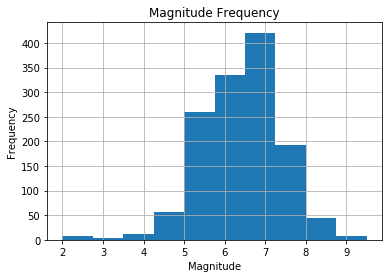

In [22]:
df.magnitude.hist()
plt.title("Magnitude Frequency")
plt.xlabel('Magnitude')
plt.ylabel('Frequency');

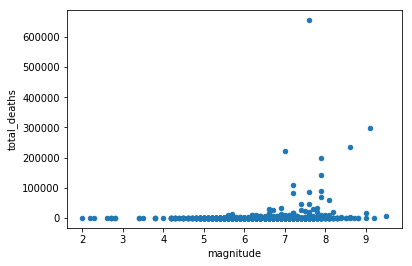

In [23]:
df.plot(kind = 'scatter', x = 'magnitude', y='total_deaths');

In [24]:
df.total_deaths.describe()

count      1340.000000
mean       2353.696269
std       23393.108847
min           0.000000
25%           2.000000
50%           8.000000
75%          76.500000
max      655237.000000
Name: total_deaths, dtype: float64

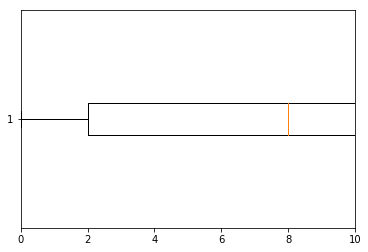

In [25]:
plt.boxplot(df.total_deaths, vert = False)
plt.xlim(0,10);

In [26]:
df = df.drop(df.index[413])

In [27]:
df

origin            country      lat       lng depth  \
0    1900-05-11 17:23:00              Japan   38.700   141.100     5   
1    1900-07-12 06:25:00             Turkey   40.300    43.100   NaN   
2    1900-10-29 09:11:00          Venezuela   11.000   -66.000     0   
3    1901-02-15 00:00:00              China   26.000   100.100     0   
4    1901-03-31 07:11:00           Bulgaria   43.400    28.700   NaN   
5    1901-08-09 09:23:00              Japan   40.500   142.500    35   
6    1901-11-15 20:15:00       New Zealand   -43.000   173.000     0   
7    1902-01-30 14:01:00              Japan   40.500   141.300    35   
8    1902-02-13 09:39:00         Azerbaijan   40.700    48.600    15   
9    1902-03-09 07:46:00             Turkey   40.700    33.600   NaN   
10   1902-04-19 02:23:00         Guatemala    14.000   -91.000     0   
11   1902-07-03 15:36:00              China   43.200   129.600    20   
12   1902-08-22 03:00:00              China   40.000    77.000     0   
13   1902-09-19 00:00:00          Australia  -35.000   138.000     2   
14   1902-12-16 05:07:00         Uzbekistan   40.800    72.300     9   
15   1903-03-29 22:30:00  Judea and Samaria   32.200    35.300   NaN   
16   1903-04-28 00:00:00            Turkey     39.14     42.65   NaN   
17   1903-05-28 03:58:00             Turkey   40.900    42.700   NaN   
18   1903-08-11 04:32:00             Greece   36.360    22.970    80   
19   1903-09-25 01:20:00               Iran   35.200    58.200   NaN   
20   1904-04-24 06:39:00             Taiwan   23.500   120.500   NaN   
21   1904-08-11 05:56:00             Greece   37.750    27.000    10   
22   1904-08-30 11:42:00              China   30.000   101.000     0   
23   1904-11-05 20:25:00            Taiwan    23.500   120.300   NaN   
24   1905-04-04 00:50:00              India   33.000    76.000     0   
25   1905-06-01 04:42:00            Albania   42.100    19.600    20   
26   1905-06-02 05:39:00              Japan   34.100   132.500    55   
27   1905-09-08 01:43:00             Italy    39.000    16.000     0   
28   1905-11-08 22:06:00             Greece   40.000    24.000     0   
29   1906-01-31 15:36:00           Ecuador     1.000   -81.500     0   
...                  ...                ...      ...       ...   ...   
1310 2008-05-25 08:21:00              China   32.560   105.423    18   
1311 2008-06-06 20:02:00            Algeria   35.883    -0.658     4   
1312 2008-06-08 12:25:00            Greece    37.963    21.525    16   
1313 2008-06-13 23:43:00             Japan    39.030   140.881     7   
1314 2008-06-17 05:51:00              China   32.761   105.554    10   
1315 2008-07-15 03:26:00            Greece    35.983    27.785    68   
1316 2008-08-21 12:24:00             China      25.1      97.9   NaN   
1317 2008-08-30 08:30:00             China      26.0     101.9    10   
1318 2008-10-05 15:52:00        Kyrgyzstan    39.515    73.768  27.6   
1319 2008-10-06 16:30:00             China       NaN       NaN   NaN   
1320 2008-10-28 23:09:00          Pakistan       NaN       NaN   NaN   
1321 2009-01-08 19:21:00        Costa Rica   10.3962  -84.0281    48   
1322 2009-04-06 03:32:00             Italy    42.334    13.334   8.8   
1323 2009-07-09 11:19:00             China       NaN       NaN   NaN   
1324 2009-08-10 20:07:00             Japan       NaN       NaN   NaN   
1325 2009-09-02 07:55:00         Indonesia       NaN       NaN   NaN   
1326 2009-09-29 17:48:00             Samoa       NaN       NaN   8.1   
1327 2009-09-30 10:16:00         Indonesia       NaN       NaN   NaN   
1328 2010-01-12 17:00:00             Haiti    18.457   -72.533    13   
1329 2010-02-27 06:34:00             Chile   -35.846   -72.719    35   
1330 2010-03-08 02:32:00            Turkey       NaN       NaN   NaN   
1331 2010-03-11 14:39:00             Chile       NaN       NaN   NaN   
1332 2010-04-14 23:49:00             China       NaN       NaN   NaN   
1333 2011-02-21 23:51:00       New Zealand       NaN      

In [28]:
df['geometry'] = df.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

In [29]:
df = df.drop(['pde_shaking_deaths','pde_total_deaths','utsu_total_deaths','emdat_total_deaths','other_deaths'], axis = 1)

# Focus
- Where would you live if you wanted to eliminate the risk of experiencing an earthquake?
- Where would you avoid living?

## About Earthquake Magnitude

<img src = "https://i.cbc.ca/1.1877835.1380772347!/httpImage/image.jpg_gen/derivatives/original_780/earthquake-magnitude.jpg" width="300" height="600" align = 'left'>

In [30]:
usa = pd.read_csv('/Users/rabram/Desktop/NSS/data-question-3-earthquakes-high-voltage-1/data/all_month.csv', usecols=[0,1,2,3,4])

In [31]:
usa.head()

time   latitude   longitude   depth   mag
0  2018-09-25T23:55:30.290Z  33.508000 -116.800667    2.71  1.42
1  2018-09-25T23:47:51.764Z  60.195300 -153.153200  132.20  1.80
2  2018-09-25T23:38:40.870Z  33.515833 -116.788333    6.66  0.47
3  2018-09-25T23:37:40.574Z  60.934000 -152.458700  105.60  1.40
4  2018-09-25T23:34:28.040Z  33.335000 -116.166667   10.31  0.86

In [32]:
usa.columns = ['time','lat','lng','depth','magnitude']

In [33]:
usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9937 entries, 0 to 9936
Data columns (total 5 columns):
time         9937 non-null object
lat          9937 non-null float64
lng          9937 non-null float64
depth        9937 non-null float64
magnitude    9935 non-null float64
dtypes: float64(4), object(1)
memory usage: 388.2+ KB


In [34]:
usa['geometry'] = usa.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

In [35]:
usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9937 entries, 0 to 9936
Data columns (total 6 columns):
time         9937 non-null object
lat          9937 non-null float64
lng          9937 non-null float64
depth        9937 non-null float64
magnitude    9935 non-null float64
geometry     9937 non-null object
dtypes: float64(4), object(2)
memory usage: 465.9+ KB


In [36]:
states = gpd.read_file('/Users/rabram/Desktop/NSS/data-question-3-earthquakes-high-voltage-1/data/gz_2010_us_040_00_5m.json')

In [37]:
usa_geo = gpd.GeoDataFrame(usa, crs = states.crs, geometry = usa['geometry'])

In [38]:
usa_by_state = gpd.sjoin(usa_geo, states)

In [39]:
usa_by_state.head()

time        lat         lng  depth  magnitude  \
0   2018-09-25T23:55:30.290Z  33.508000 -116.800667   2.71       1.42   
2   2018-09-25T23:38:40.870Z  33.515833 -116.788333   6.66       0.47   
4   2018-09-25T23:34:28.040Z  33.335000 -116.166667  10.31       0.86   
5   2018-09-25T23:34:09.460Z  38.828335 -122.784164   1.38       0.72   
11  2018-09-25T23:05:50.640Z  33.104500 -116.427167  11.71       1.11   

                           geometry  index_right       GEO_ID STATE  \
0       POINT (-116.8006667 33.508)            4  0400000US06    06   
2   POINT (-116.7883333 33.5158333)            4  0400000US06    06   
4       POINT (-116.1666667 33.335)            4  0400000US06    06   
5   POINT (-122.7841644 38.8283348)            4  0400000US06    06   
11     POINT (-116.4271667 33.1045)            4  0400000US06    06   

          NAME LSAD  CENSUSAREA  
0   California        155779.22  
2   California        155779.22  
4   California        155779.22  
5   California        155779.22  
11  California        155779.22

In [40]:
usa_lower48 = usa_by_state.loc[usa_by_state['NAME'] != "Alaska"]
usa_lower48 = usa_lower48.loc[usa_lower48['NAME'] != 'Hawaii']

# This map plots all earthquakes in the Lower 48 states of the USA in September 2018.

In [41]:
map_earthquakes = folium.Map(location = [36.04173095575453, -86.63636274154366], zoom_start = 4)

mc = MarkerCluster()

for row in usa_lower48.iterrows():
    row_values = row[1] 
    mc.add_child(folium.Marker(location=[row_values['lat'],  row_values['lng']]))
    
map_earthquakes.add_child(mc) 

map_earthquakes

In [42]:
world2018 = pd.read_csv('/Users/rabram/Desktop/NSS/data-question-3-earthquakes-high-voltage-1/data/query (1).csv')

In [43]:
world2018.head()

time  latitude  longitude   depth  mag magType  nst  \
0  2018-09-28T00:26:30.550Z   37.0440    30.4969  106.17  4.0      mb  NaN   
1  2018-09-27T23:36:51.500Z   -7.4532   128.5127  154.42  4.5      mb  NaN   
2  2018-09-27T22:25:43.970Z  -18.1652  -178.2429  540.20  5.5     mww  NaN   
3  2018-09-27T22:00:21.110Z  -11.3478   -76.7084   44.89  4.8      mb  NaN   
4  2018-09-27T21:45:16.567Z   56.4112  -148.4244   10.00  3.0      ml  NaN   

     gap   dmin   rms    ...                      updated  \
0   96.0  0.556  0.83    ...     2018-09-28T00:47:25.445Z   
1   65.0  2.810  1.03    ...     2018-09-28T00:29:46.040Z   
2   34.0  3.550  1.10    ...     2018-09-28T00:27:52.125Z   
3  100.0  0.649  0.76    ...     2018-09-27T23:07:24.556Z   
4    NaN    NaN  0.63    ...     2018-09-27T22:38:53.471Z   

                             place        type horizontalError depthError  \
0       23km NW of Antalya, Turkey  earthquake             5.4        6.3   
1  Kepulauan Barat Daya, Indonesia  earthquake             7.1        8.0   
2     279km N of Ndoi Island, Fiji  earthquake             8.8        6.4   
3    55km N of Santa Eulalia, Peru  earthquake             7.2        8.6   
4      286km ESE of Kodiak, Alaska  earthquake             NaN        0.0   

   magError  magNst    status  locationSource magSource  
0     0.108    23.0  reviewed              us        us  
1     0.093    34.0  reviewed              us        us  
2     0.073    18.0  reviewed              us        us  
3     0.049   127.0  reviewed              us        us  
4       NaN     NaN  reviewed              ak        ak  

[5 rows x 22 columns]

# This map shows all earthquakes in the world with a magnitude of 2.5 or higher in September 2018.

In [44]:
world_earthquakes = folium.Map(location = [36.04173095575453, -86.63636274154366], zoom_start = 4)

mc = MarkerCluster()

for row in world2018.iterrows():
    row_values = row[1] 
    mc.add_child(folium.Marker(location=[row_values['latitude'],  row_values['longitude']]))
    
world_earthquakes.add_child(mc) 

world_earthquakes

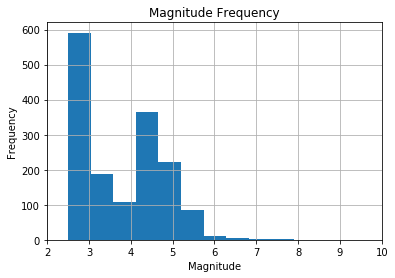

In [104]:
world2018.hist('mag')
plt.title('Magnitude Frequency')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.xlim(2,10);

In [46]:
countries = gpd.read_file('/Users/rabram/Desktop/NSS/data-question-3-earthquakes-high-voltage-1/data/world-countries.json')

In [47]:
world2018['geometry'] = world2018.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis=1)

In [48]:
world_geo_2018 = gpd.GeoDataFrame(world2018, crs = countries.crs, geometry = world2018['geometry'])

In [49]:
world_all_2018 = gpd.sjoin(world_geo_2018, countries)

In [50]:
world2008 = pd.read_csv('/Users/rabram/Desktop/NSS/data-question-3-earthquakes-high-voltage-1/data/2008quakes.csv')

In [51]:
world1998 = pd.read_csv('/Users/rabram/Desktop/NSS/data-question-3-earthquakes-high-voltage-1/data/1998quakes.csv')

# This map shows all earthquakes in the world with a magnitude of 2.5 or higher in September 2008.

In [52]:
world_2008 = folium.Map(location = [36.04173095575453, -86.63636274154366], zoom_start = 4)

mc = MarkerCluster()

for row in world2008.iterrows():
    row_values = row[1] 
    mc.add_child(folium.Marker(location=[row_values['latitude'],  row_values['longitude']]))
    
world_2008.add_child(mc) 

world_2008

# This map shows all earthquakes in the world with a magnitude of 2.5 or higher in September 1998.

In [53]:
world_1998 = folium.Map(location = [36.04173095575453, -86.63636274154366], zoom_start = 4)

mc = MarkerCluster()

for row in world1998.iterrows():
    row_values = row[1] 
    mc.add_child(folium.Marker(location=[row_values['latitude'],  row_values['longitude']]))
    
world_1998.add_child(mc) 

world_1998

In [54]:
world2008['geometry'] = world2008.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis=1)
world1998['geometry'] = world1998.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis=1)

In [55]:
world_geo_2008 = gpd.GeoDataFrame(world2008, crs = countries.crs, geometry = world2008['geometry'])
world_geo_1998 = gpd.GeoDataFrame(world1998, crs = countries.crs, geometry = world1998['geometry'])

In [56]:
world_all_2008 = gpd.sjoin(world_geo_2008, countries)
world_all_1998 = gpd.sjoin(world_geo_1998, countries)

In [57]:
country_quake_count = world_all_2018.name.value_counts()

In [58]:
country_quake_count = pd.DataFrame(country_quake_count).reset_index()

In [59]:
country_quake_count.columns = ['country','2018_count']

In [60]:
counts_08 = world_all_2008.name.value_counts()
counts_08 = pd.DataFrame(counts_08).reset_index()
counts_08.columns = ['country','2008_count']

In [61]:
country_quake_count = pd.merge(country_quake_count, counts_08, how = 'outer')

In [62]:
counts_98 = world_all_1998.name.value_counts()
counts_98 = pd.DataFrame(counts_98).reset_index()
counts_98.columns = ['country','1998_count']

In [63]:
country_quake_count = pd.merge(country_quake_count, counts_98, how = 'outer')

In [64]:
country_quake_count = country_quake_count.fillna(0)

<h1> Analysis pt. 2 9/29 </h1>

In [65]:
df = pd.DataFrame(df[pd.notnull(df['lat'])])

In [67]:
#df = df.drop([413])

In [68]:
df['lat'] = pd.to_numeric(df['lat'])
df['lng'] = pd.to_numeric(df['lng'])

In [69]:
df_7 = pd.DataFrame(df.loc[df['magnitude'] < 5.0])

In [70]:
#df_7 = pd.DataFrame(df_7.loc[df_7['total_deaths'] < 100000])

In [71]:
df_7 = pd.DataFrame(df_7.loc[df_7['total_deaths'] > 5])

In [72]:
# bins = pd.IntervalIndex.from_tuples([(-1, 1000), (1000, 10000), (10000, 100000)])
df_7['marker_color'] = pd.cut(df_7['total_deaths'], bins = 2, labels=['red','blue'])

# This map shows all earthquakes with a magnitude lower than 5.0 that resulted in deaths. The two earthquakes marked in blue had deaths higher than average.

In [102]:
deaths = folium.Map(location = [55,35], zoom_start = 2)

for row in df_7.iterrows():
    row_values = row[1] 
    location=[row_values['lat'], row_values['lng']]
    color = row_values['marker_color']
    popup = (str(row_values['country'] + '<br> Date: ' + str(row_values['origin']) + '<br> Magnitude: ' + str(row_values['magnitude'])+ '<br>Total Deaths: ' + str(row_values['total_deaths'])))
    marker = folium.Marker(location=location, popup=popup, icon=folium.Icon(color=color))
    
    marker.add_to(deaths)

deaths

## This map plots all the significant earthquakes scraped from the Wiki page.

In [74]:
significant = folium.Map(location = [36.04173095575453, -86.63636274154366], zoom_start = 4)

mc = MarkerCluster()

for row in df.iterrows():
    row_values = row[1] 
    popup = (str(row_values['country'] + '<br> Date: ' + str(row_values['origin']) + '<br> Magnitude: ' + str(row_values['magnitude'])+ '<br>Total Deaths: ' + str(row_values['total_deaths'])))
    mc.add_child(folium.Marker(location=[row_values['lat'],  row_values['lng']], popup=popup))
    
significant.add_child(mc) 
    
significant

In [75]:
df_no_deaths = df.loc[df['total_deaths'] == 0]
df_only_deaths = df.loc[df['total_deaths'] != 0]

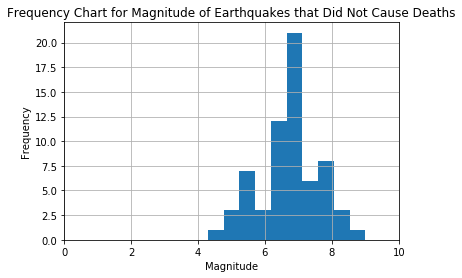

In [76]:
df_no_deaths.magnitude.hist();
plt.title('Frequency Chart for Magnitude of Earthquakes that Did Not Cause Deaths')
plt.xlabel('Magnitude')
plt.xlim(0,10)
plt.ylabel('Frequency');

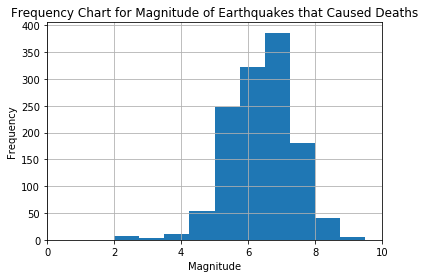

In [77]:
df_only_deaths.magnitude.hist();
plt.title('Frequency Chart for Magnitude of Earthquakes that Caused Deaths')
plt.xlabel('Magnitude')
plt.xlim(0,10)
plt.ylabel('Frequency');

In [78]:
df_no_deaths.magnitude.max()

9.0

In [79]:
df_only_deaths.magnitude.min()

2.0

## The smallest earthquake that caused deaths had a magnitude of 2.0.
## The largest earthquake that did not cause any deaths had a magnitude of 9.0.

In [80]:
df_no_deaths.loc[df['magnitude'] > 8.4]

origin              country     lat      lng depth  \
112 1923-02-03 16:01:00   Russian Federation  53.853  160.761    35   
332 1952-11-04 16:58:00  Russian Federation   52.755  160.057  22.2   

     magnitude secondary_effects  total_deaths                geometry  
112        8.5                 T           0.0  POINT (160.761 53.853)  
332        9.0                 T           0.0  POINT (160.057 52.755)

### These data points are inaccurate - at the time of these incidents, Russia was under communist rule and it's unlikely that they correctly reported the number of deaths. It's highly improbable that earthquake with a magnitude of 9.0 or of 8.5 resulted in 0 deaths. I will drop these two data points.

In [81]:
df_no_deaths = df_no_deaths.drop([332])
df_no_deaths = df_no_deaths.drop([112
                                 
                                 ])

In [82]:
df_no_deaths.magnitude.max()

8.3

In [83]:
df_no_deaths.loc[df['magnitude'] == 8.3]

origin       country    lat      lng depth  magnitude  \
123 1924-04-14 16:20:00  Philippines   7.023  125.954    33        8.3   

    secondary_effects  total_deaths               geometry  
123               NaN           0.0  POINT (125.954 7.023)

In [84]:
sub5_deadly = pd.DataFrame(df_only_deaths.loc[df['magnitude'] <= 5.0])

In [85]:
df_phil = df.loc[df['country'] == 'Philippines']


In [86]:
df_phil = pd.DataFrame(df_phil.loc[df_phil['magnitude'] >= 7.0])

In [87]:
df_phil = df_phil.sort_values('total_deaths')

In [88]:
df_phil['marker_color'] = pd.cut(df_phil['total_deaths'], bins=2, labels=['blue','red'])

In [89]:
df_phil.describe()

lat         lng  magnitude  total_deaths
count  19.000000   19.000000  19.000000     19.000000
mean   11.099632  123.101474   7.384211     78.421053
std     4.136447    1.977706   0.327046    165.115891
min     5.321000  119.776000   7.100000      0.000000
25%     7.322500  121.829500   7.150000      2.000000
50%    11.390000  122.878000   7.300000     15.000000
75%    14.159000  123.890500   7.500000     76.500000
max    18.000000  127.257000   8.200000    600.000000

In [90]:
df.describe()

lat          lng    magnitude   total_deaths
count  1325.000000  1325.000000  1324.000000    1325.000000
mean     21.411408    39.198997     6.396224    2375.978868
std      21.462911    80.105326     0.970012   23524.183218
min     -54.000000  -178.162000     2.000000       0.000000
25%       8.267000    -0.570000     5.700000       2.000000
50%      29.009000    51.565000     6.400000       8.000000
75%      38.000000   103.672000     7.100000      75.000000
max      66.226000   178.291000     9.500000  655237.000000

## Weird comparison:
- Average Significant Earthquake in World has a magnitude of 6.4 and death count of 2375.
- Average Significant Earthquake in the Phillipenes has a magnitude of 7.4 and death count of 78.

# Below is a map off all significant earthquakes in the Phillipenes. The red marks show earthquakes that a death toll greater than 100.

In [91]:
phill = folium.Map(location = [12, 125], zoom_start = 6)

for row in df_phil.iterrows():
    row_values = row[1] 
    location = [row_values['lat'], row_values['lng']]
    popup = (str(row_values['country'] + '<br> Date: ' + str(row_values['origin']) + '<br> Magnitude: ' + str(row_values['magnitude'])+ '<br>Total Deaths: ' + str(row_values['total_deaths'])))
    marker = folium.Marker(location=location, popup=popup, icon=folium.Icon(color=row_values['marker_color']))
    
    marker.add_to(phill)
    
phill

In [92]:
df_phil['marker_color'] = pd.cut(df_phil['total_deaths'], bins=2, labels=['blue','red'])